# Abridged CHART Analysis Tutorial

This abridged version of the CHART analysis tutorial is meant to be a quick check for your data. For full explanation of the steps and deeper analysis, see the "CHART Analysis Tutorial" notebook.

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import chart
from astropy import units as u
from astropy.coordinates import SpectralCoord, EarthLocation, SkyCoord, AltAz, ICRS
from astropy.time import Time
import pandas as pd
from ipywidgets import interact, FloatSlider, Dropdown
import scipy.constants as const

In [2]:
# Rest frequency of HI hyperfine transition
f_e = 1.420405751768 * u.GHz

## Reading in data

We will use two *variables* to point the program to your data. Once we set the variables, they can be re-used throughout the notebook.
1. The `data_dir` variable indicates the larger file tree where your observations are located. We use quotes around the value of the variable to tell python that the variable is a *string*. Here, ours is called `'test_data/'`. 
2. The `paths` variable is a list of your observations within the `data_dir` directory. We use square brackets, `[ ]` to indicate a list, and each item in the list is wrapped in quotes to show they are strings. There may be more or less than three paths depending on how many observations you took. You can simply add more to the list if you have more than three.

If you would like to use the test data, you do not need to change anything in this cell. However, if you would like to use your own data, you just need to change the variables listed above.

Once you have pointed to your data, run the cell below.

In [3]:
### Change these variables to use your own data ###
data_dir = 'test_data/'
paths = ['abeardsley_Winona-HS-Park_2022.10.08_1_6.12_pm',
         'abeardsley_Winona-HS-Park_2022.10.8_2_6.25_pm',
         'abeardsley_Winona-HS-Park_2022.10.8_3_6.30_pm']

ntrials = len(paths)
stack_figsize = (6, ntrials * 2.5)
single_figsize = (6, 4)

data = []
mdata = []
bps = []  # bandpasses

for i in range(ntrials):
    d, m = chart.analysis.read_run(directory=data_dir + paths[i])
    d = np.array(d)
    data.append(d)
    mdata.append(m)
    # Rough estimate for bandpass
    nchans = m[0]['vector_length']
    levels = np.median(d[:, :, nchans // 4:(-nchans // 4)], axis=(1, 2))
    rescaled = d / levels.reshape(-1, 1, 1)
    bp = np.median(rescaled, axis=(0, 1))
    bps.append(bp)


The next cell plots the raw CHART data for each observation. The x-axis represents the recorded frequencies in Gigahertz (GHz) and the y-axis shows the signal strength in decibels (dB) for each frequency. You do not need to make any modifications to this cell.

<IPython.core.display.Javascript object>


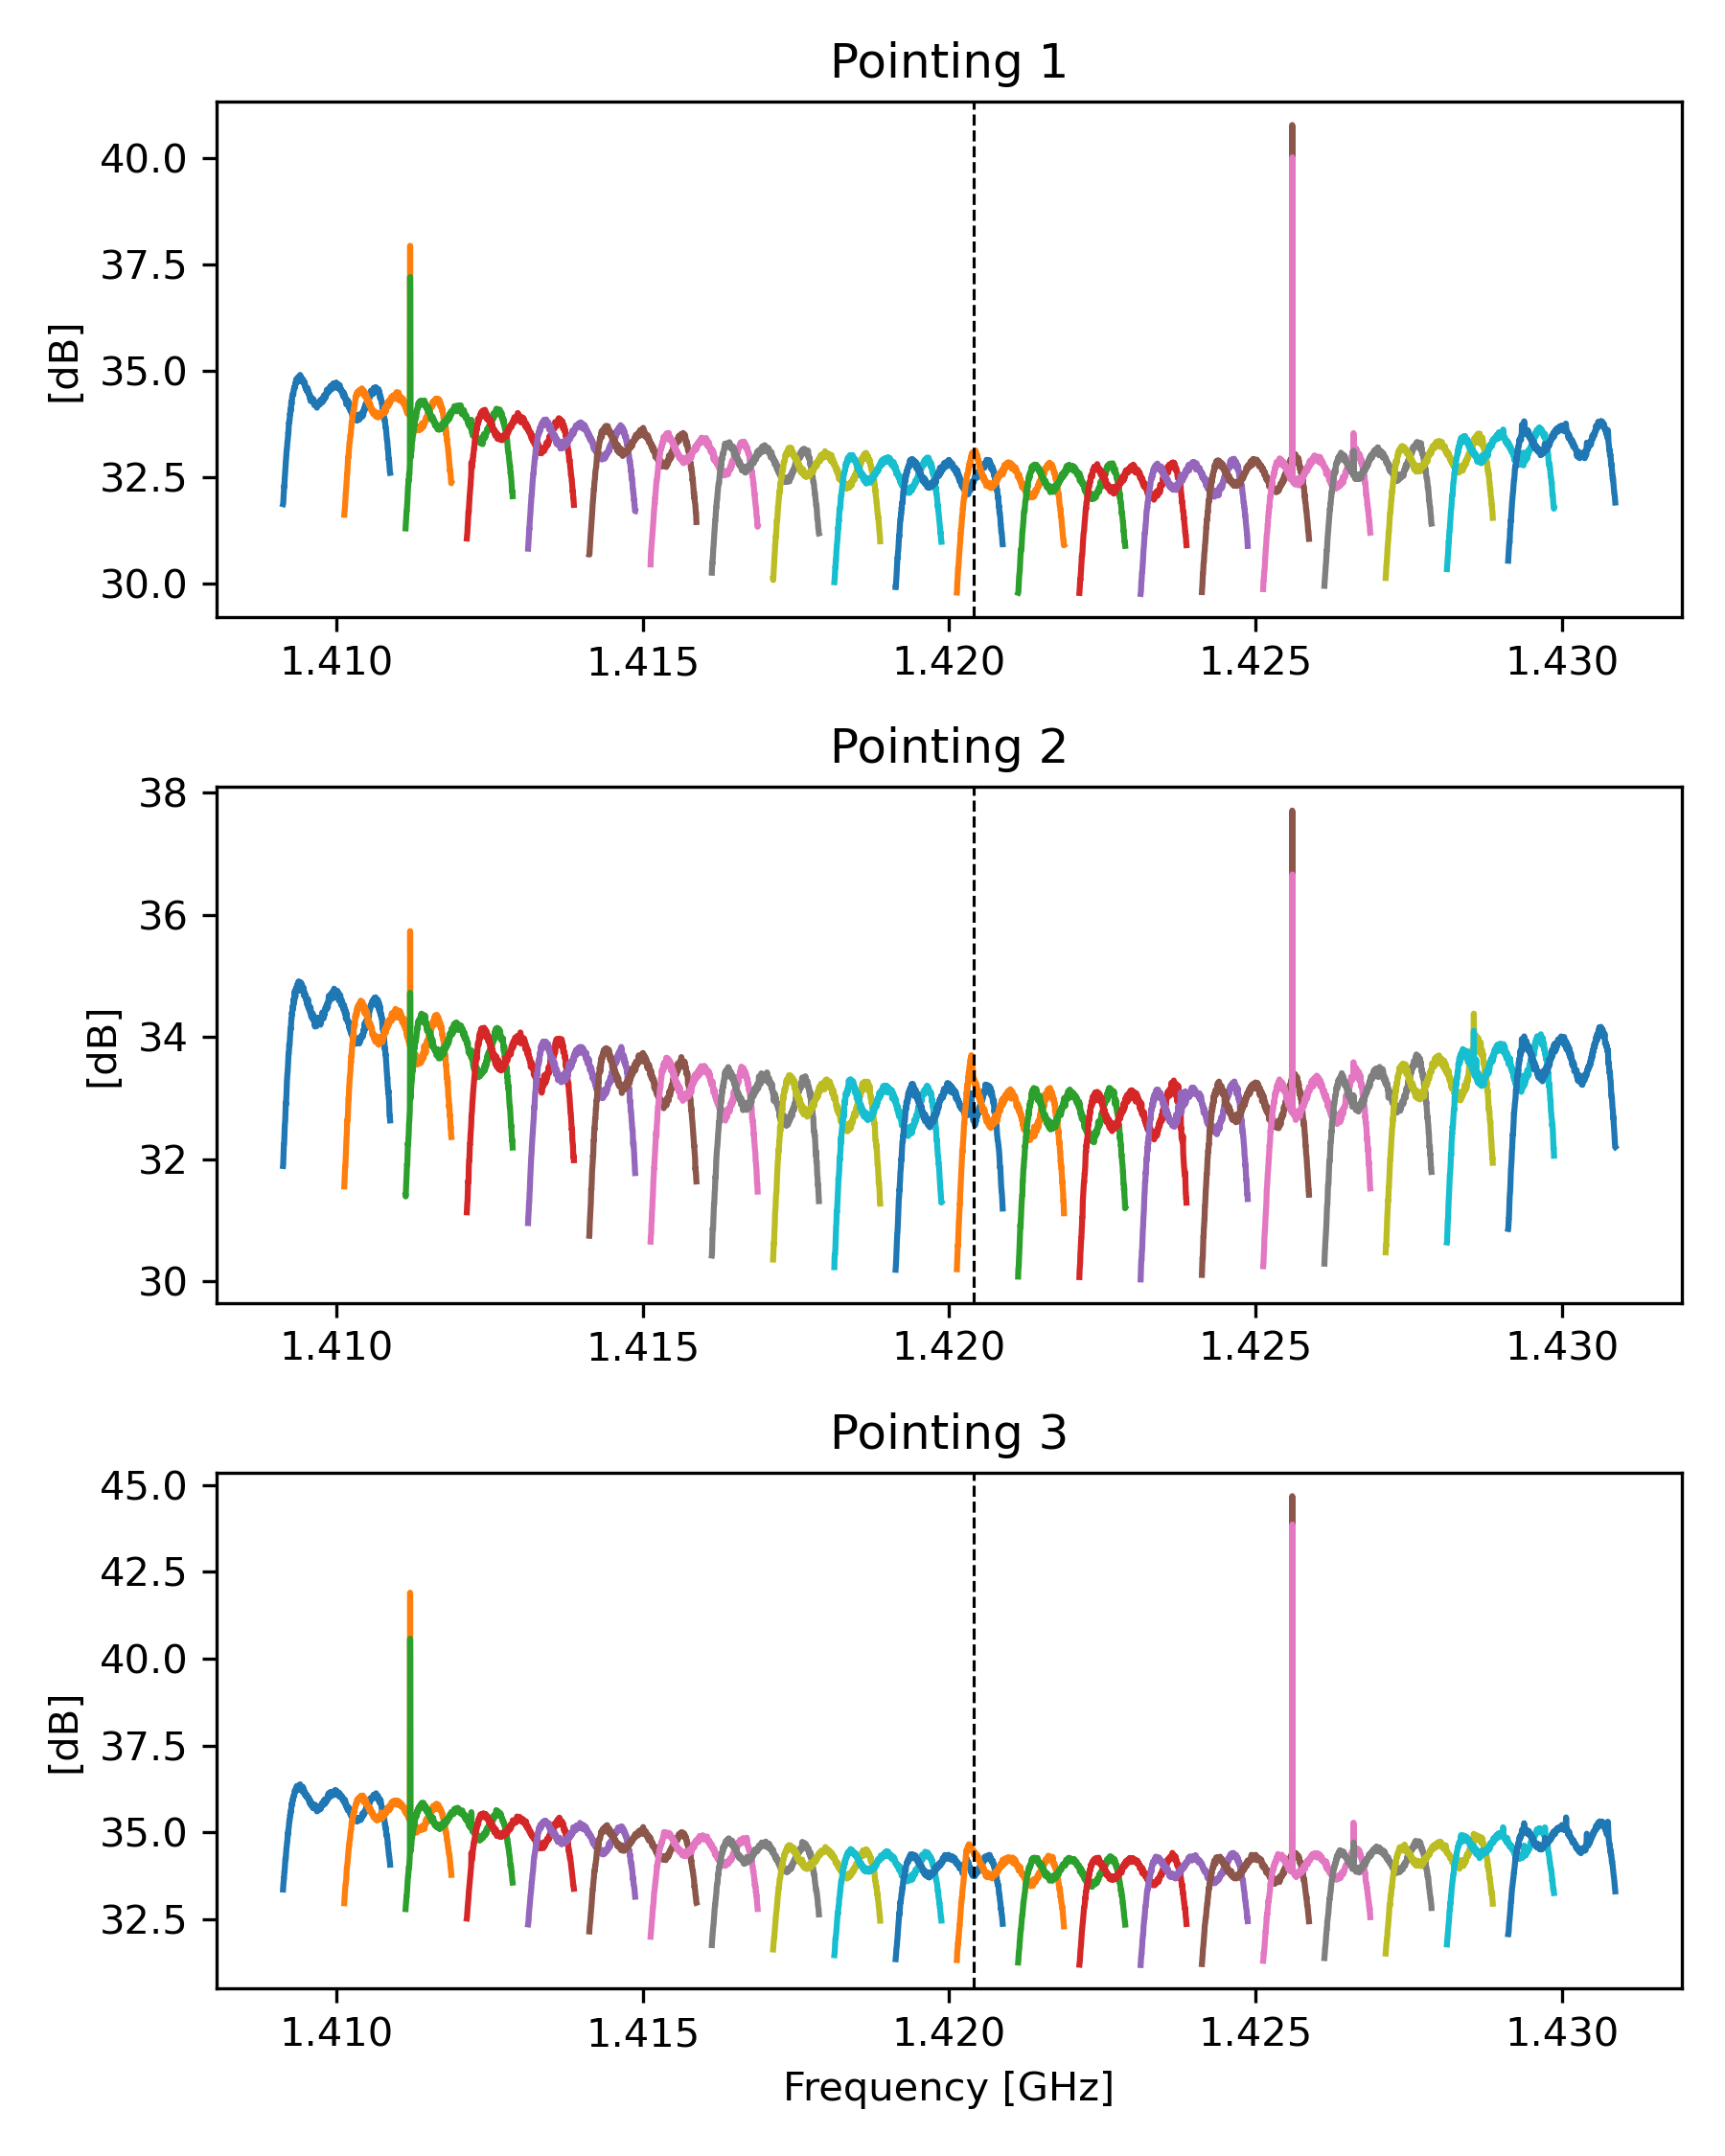

In [4]:
ntrials = len(data)
spectra = [[] for _ in range(ntrials)]
freqs = [[] for _ in range(ntrials)]
nremove = nchans // 16

for pointing in range(ntrials):
    for d, m in zip(data[pointing], mdata[pointing]):
        spectrum = np.mean(d, axis=0) 
        spectrum = 10*np.log10(spectrum)
        spectrum = spectrum[nremove:-nremove]
        frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                           * m['samp_rate'] / m['vector_length'] + m['frequency'])
        frequencies = 1e-9 * frequencies[nremove:-nremove]
        spectra[pointing].append(spectrum)
        freqs[pointing].append(frequencies)

fig, axs = plt.subplots(ntrials, 1, figsize=stack_figsize)
if ntrials == 1: axs = [axs]
for pointing in range(ntrials):
    for f, s in zip(freqs[pointing], spectra[pointing]):
        axs[pointing].plot(f, s)
    axs[pointing].set_title(f'Pointing {pointing+1}')
    axs[pointing].set_ylabel('[dB]')
    axs[pointing].axvline(f_e.value, c='k', linestyle='--', linewidth=0.75)
 
plt.xlabel('Frequency [GHz]')
plt.tight_layout()

## Basic conversions and corrections

### Bandpass and automatic gain correction

The following cell fits for and removes the bandpass filter that was applied to the data by the SDR. It also corrects for any amplification done by the automatic 
After the data is collected from the antenna it passes through a bandpass filter located in our SDR. A bandpass filter is used to isolate a specific frequency range of interest from the broader spectrum of electromagnetic radiation received by the telescope. This filter allows signals within the desired bandpass to pass through with little interference while blocking signals outside that range. However, this bandpass filter has a frequency-dependent response that imparts a shape onto our data. This is the repeating stucture seen in each tuning above. The next cell will calibrate for this bandpass, removing that shape from the data. 

In addition, the SDR will automatically amplify or reduce the signal to ensure the best data possible without saturating the electronics. This is a great feature, but we need to correct for it when analyzing the data. We do this by forcing overlapping data to match levels, on average.

There still may be some overall shape across the whole frequency range caused by frequency dependence of the electronics, but we don't worry about that as our 21-cm signal is in a fairly narrow range. If the 21-cm signal is visible in your data, you should now be able to see it near the line that indicates the rest frequency after running the cell below! You do not need to make any modifications to this cell.

<IPython.core.display.Javascript object>


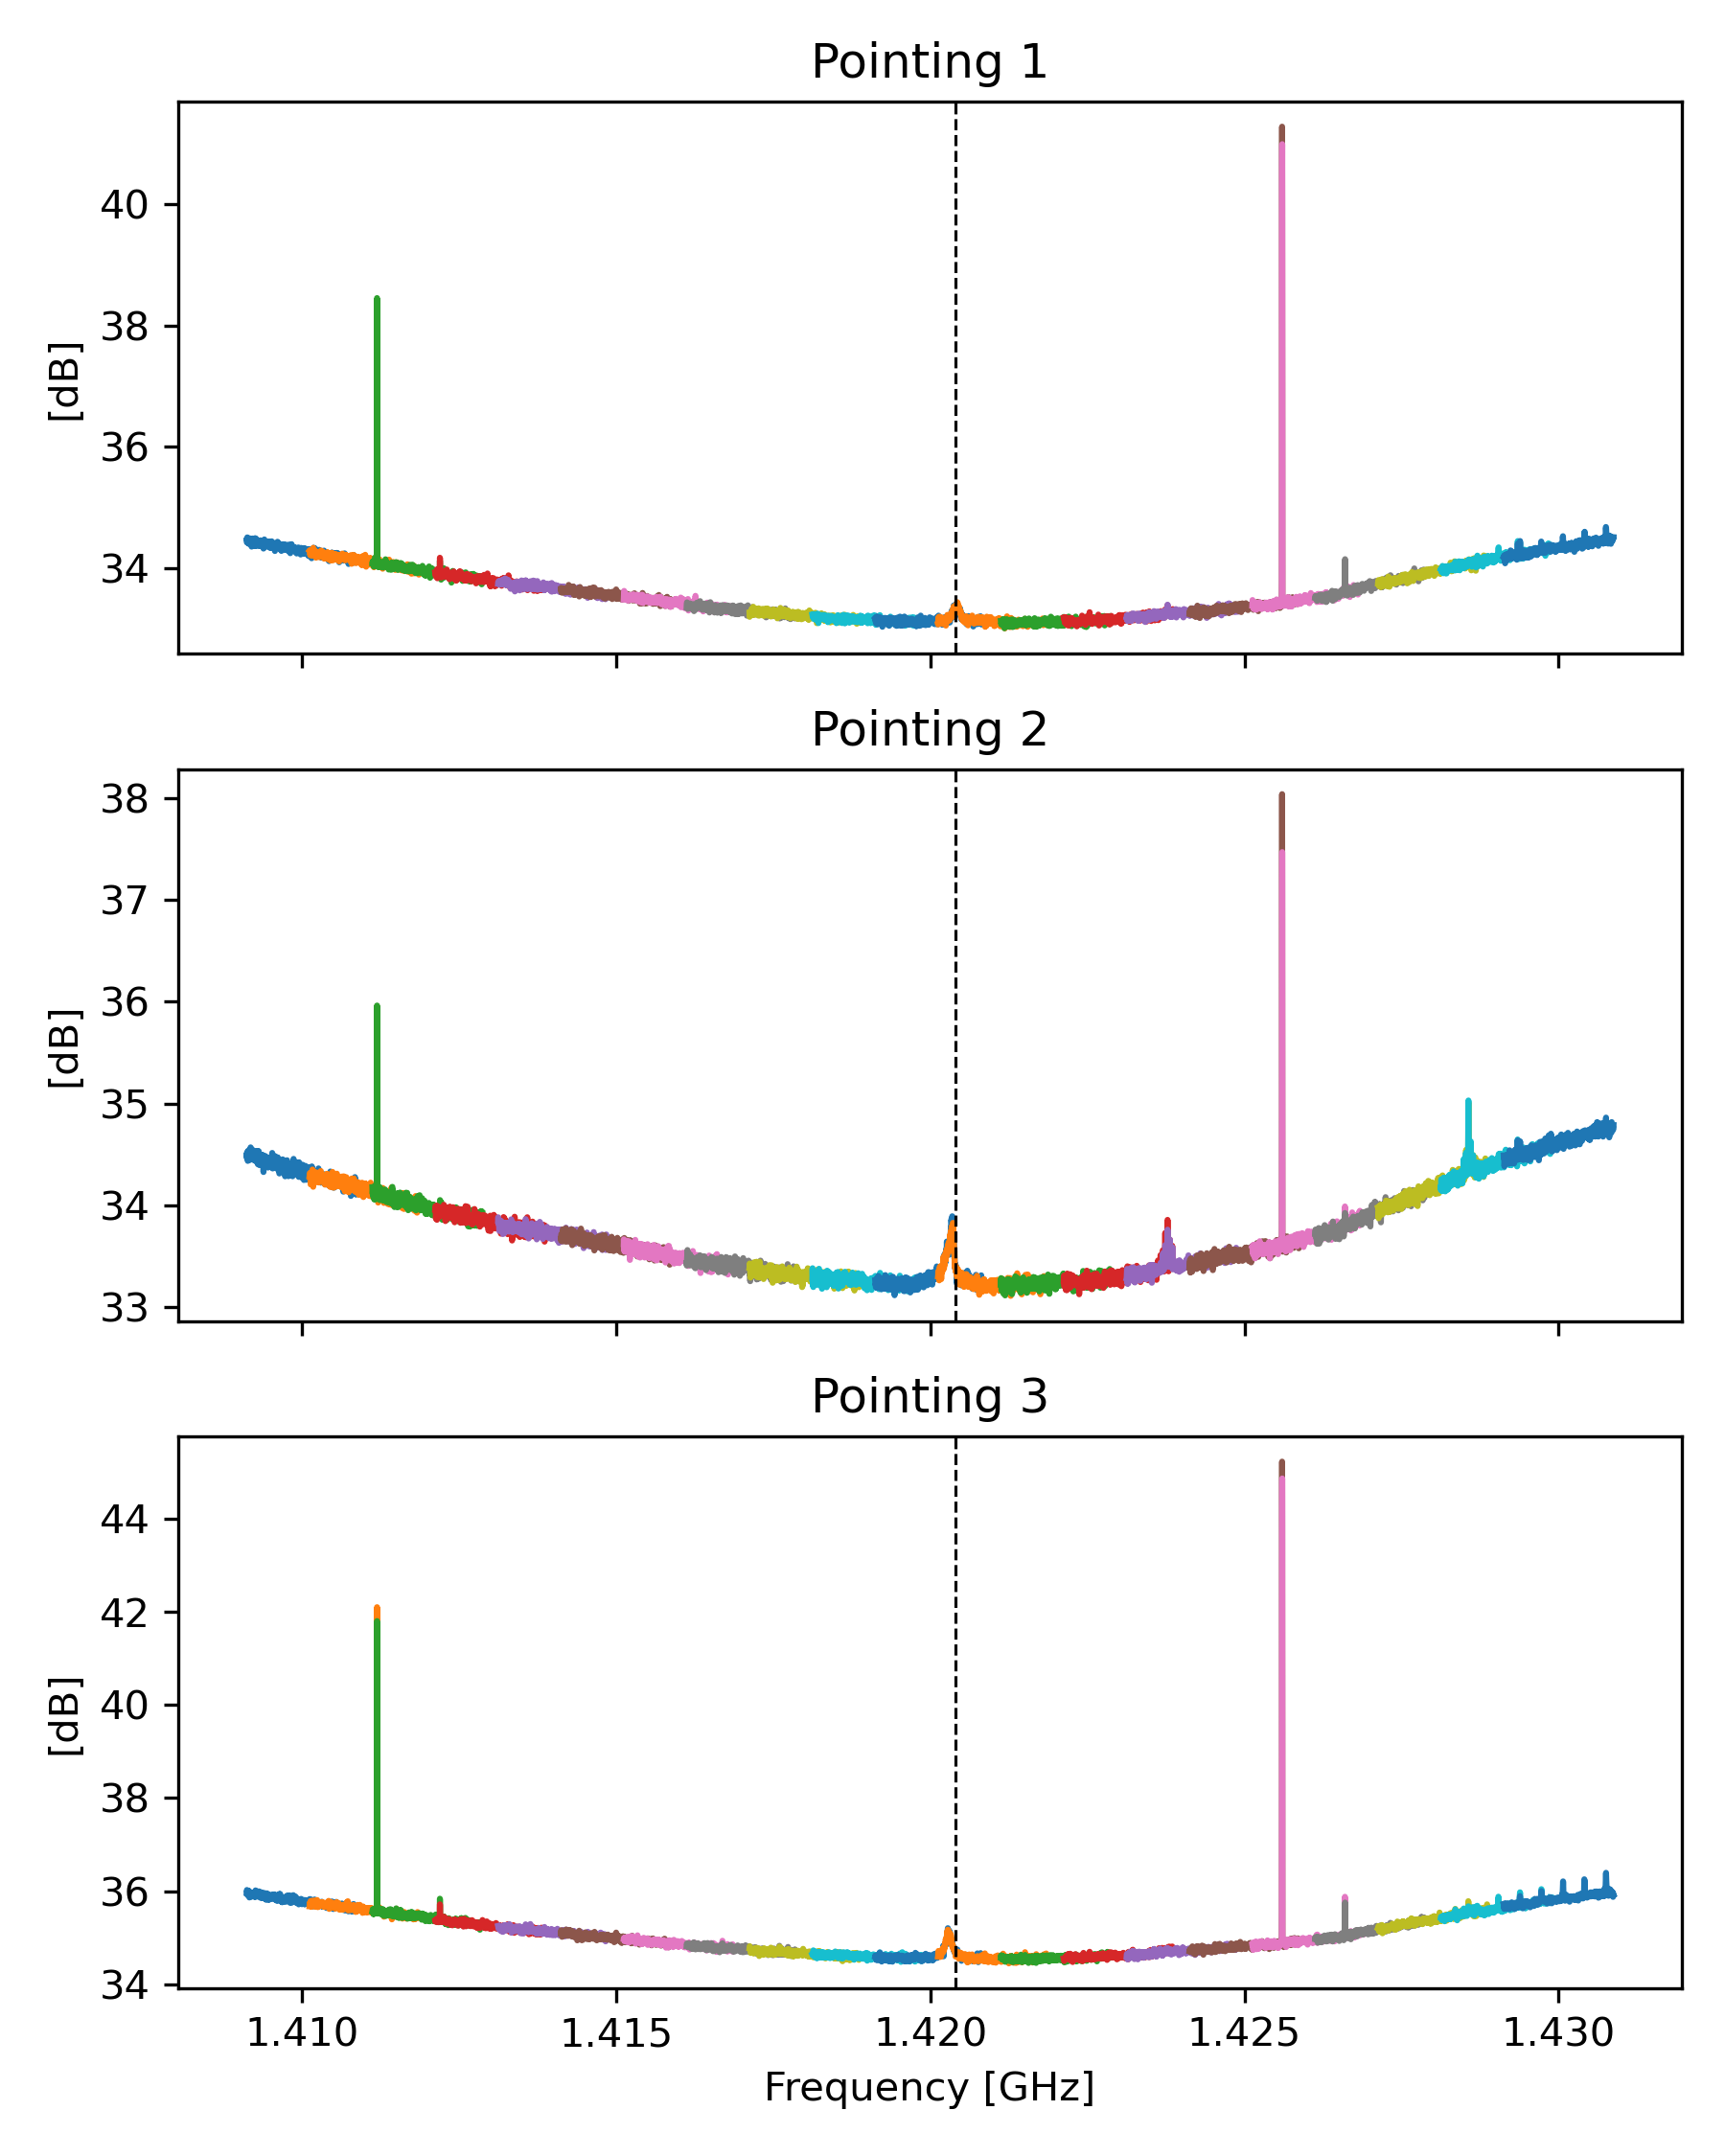

In [5]:
ntrials = len(data)
spectra = [[] for _ in range(ntrials)]
freqs = [[] for _ in range(ntrials)]
nremove = nchans // 16

for pointing in range(ntrials):
    for d, m in zip(data[pointing], mdata[pointing]):
        spectrum = np.mean(d, axis=0) /bps[0]
        spectrum = 10*np.log10(spectrum)
        spectrum = spectrum[nremove:-nremove]
        frequencies = ((np.arange(m['vector_length']) - m['vector_length'] / 2)
                           * m['samp_rate'] / m['vector_length'] + m['frequency'])
        frequencies = 1e-9 * frequencies[nremove:-nremove]
        spectra[pointing].append(spectrum)
        freqs[pointing].append(frequencies)

    for k in range(len(spectra[pointing]) - 1):
        spec1 = spectra[pointing][k]
        spec2 = spectra[pointing][k + 1]
        freq1 = freqs[pointing][k]
        freq2 = freqs[pointing][k + 1]
        ncommon = np.sum([1 if f in freq2 else 0 for f in freq1])
        spec2 += np.median(spec1[-ncommon:]) - np.median(spec2[:ncommon])
        spectra[pointing][k + 1] = spec2
        
fig, axs = plt.subplots(ntrials, 1, sharex=True, figsize=stack_figsize)
if ntrials == 1: axs = [axs]
for pointing in range(ntrials):
    for f, s in zip(freqs[pointing], spectra[pointing]):
        axs[pointing].plot(f, s)
    axs[pointing].set_title(f'Pointing {pointing+1}')
    axs[pointing].set_ylabel('[dB]')
    axs[pointing].axvline(f_e.value, c='k', linestyle='--', linewidth=0.75)

plt.xlabel('Frequency [GHz]')
plt.tight_layout()